In [1]:
#%pip install torch
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score

### Read in the file of only HAM emails (previously obtained from the CEAS_08_cleaned.csv dataset.

In [2]:
df_ham = pd.read_csv("ham.csv")
df_ham

,sender,subject,body,label,urls
0,Michael Parker <ivqrnai@pobox.com>,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
1,qydlqcws-iacfym@issues.apache.org,[Bug 5780] URI processing turns uuencoded stri...,http://issues.apache.org/SpamAssassin/show_bug...,0,1
2,Racing <uqyrmo@sailing.ie>,RE: Trial IRC Certificate Application,"\nPlelim,\n\nJust to remind you that if a cert...",0,1
3,Aaron Kulkis <cmiqlkx91@hotpop.com>,"Re: [opensuse] Why can't I use ""shutdown now"" ...",Carlos E. R. wrote: > -----BEGIN PGP SIGNED ME...,0,1
4,Aaron Kulkis <cmiqlkx91@hotpop.com>,Re: Fwd: [opensuse] Re: openSUSE Boxed Editions,Steve Jacobs wrote: > ---------- Forwarded mes...,0,1
...,...,...,...,...,...
17307,robert healy <vrcjauctt@gmail.com>,I want to cancel my account,How do I cancel my account. I want to erase i...,0,0
17308,Nick Zeljkovic <kppyozizjt@site5.com>,RE: [opensuse] Apache and SSL,\nI don't use virtual hosts. Here is the entry...,0,1
17309,Abhijit Vyas <xpojhbz@gmail.com>,Slideshow viewer,Hello there ! \nGreat work on the slide show v...,0,0
17310,Joseph Brennan <vupzesm@columbia.edu>,Note on 2-digit years,"\nMail from sender , coming from intuit.com\ns...",0,0


### Read in the file of only SPAM emails.

In [3]:
df_spam = pd.read_csv("spam.csv")
df_spam

,sender,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Gretchen Suggs <externalsep1@loanofficertool.com>,SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1
4,Caroline Aragon <dwthaidomainnamesm@thaidomain...,From Caroline Aragon,\n\n\n\n\nYo wu urS mo ou go rc ebo eForM rgi ...,1,0
...,...,...,...,...,...
21837,Amandalee <tamekut_1991@smarttech.com>,Be larger than ever after 2 months,The cure for dysfunction and impotency availab...,1,1
21838,CNN Alerts <tidhamsu_2002@tyler.sprnet.org>,CNN Alerts: My Custom Alert,\n\n\nCNN Alerts: My Custom Alert\n\n\n\n\n\n\...,1,0
21839,Amee Zeisler <dlintentions@ctk.cz>,Patients can access Our online health shop is ...,\n\nLab-tested female sensual leverage!\n\nPat...,1,0
21840,CNN Alerts <charlene-detecton@btcmarketing.com>,CNN Alerts: My Custom Alert,\n\nCNN Alerts: My Custom Alert\n\n\n\n\n\n\n ...,1,0


### Remove the \n characters in HAM. Replace them with spaces, since they don't add anything to the analysis.

In [4]:
df_ham['body'] = df_ham['body'].str.replace(r'\n', ' ', regex=True)
df_ham

,sender,subject,body,label,urls
0,Michael Parker <ivqrnai@pobox.com>,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
1,qydlqcws-iacfym@issues.apache.org,[Bug 5780] URI processing turns uuencoded stri...,http://issues.apache.org/SpamAssassin/show_bug...,0,1
2,Racing <uqyrmo@sailing.ie>,RE: Trial IRC Certificate Application,"Plelim, Just to remind you that if a certifi...",0,1
3,Aaron Kulkis <cmiqlkx91@hotpop.com>,"Re: [opensuse] Why can't I use ""shutdown now"" ...",Carlos E. R. wrote: > -----BEGIN PGP SIGNED ME...,0,1
4,Aaron Kulkis <cmiqlkx91@hotpop.com>,Re: Fwd: [opensuse] Re: openSUSE Boxed Editions,Steve Jacobs wrote: > ---------- Forwarded mes...,0,1
...,...,...,...,...,...
17307,robert healy <vrcjauctt@gmail.com>,I want to cancel my account,How do I cancel my account. I want to erase i...,0,0
17308,Nick Zeljkovic <kppyozizjt@site5.com>,RE: [opensuse] Apache and SSL,I don't use virtual hosts. Here is the entry ...,0,1
17309,Abhijit Vyas <xpojhbz@gmail.com>,Slideshow viewer,Hello there ! Great work on the slide show vi...,0,0
17310,Joseph Brennan <vupzesm@columbia.edu>,Note on 2-digit years,"Mail from sender , coming from intuit.com ser...",0,0


### Similarly remove the \n characters in SPAM and replace them with spaces.

In [5]:
df_spam['body'] = df_spam['body'].str.replace(r'\n', ' ', regex=True)
df_spam

,sender,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,Befriend Jenna Jameson,Upgrade your sex and pleasures with these tec...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Gretchen Suggs <externalsep1@loanofficertool.com>,SpecialPricesPharmMoreinfo,WelcomeFastShippingCustomerSupport http://7iw...,1,1
4,Caroline Aragon <dwthaidomainnamesm@thaidomain...,From Caroline Aragon,Yo wu urS mo ou go rc ebo eForM rgi oreWo...,1,0
...,...,...,...,...,...
21837,Amandalee <tamekut_1991@smarttech.com>,Be larger than ever after 2 months,The cure for dysfunction and impotency availab...,1,1
21838,CNN Alerts <tidhamsu_2002@tyler.sprnet.org>,CNN Alerts: My Custom Alert,CNN Alerts: My Custom Alert Aler...,1,0
21839,Amee Zeisler <dlintentions@ctk.cz>,Patients can access Our online health shop is ...,Lab-tested female sensual leverage! Patient...,1,0
21840,CNN Alerts <charlene-detecton@btcmarketing.com>,CNN Alerts: My Custom Alert,CNN Alerts: My Custom Alert Alert...,1,0


### There were some null elements in the subject and body, and these must be removed before TfIdfVectorization.
### Concatenated Sender, Subject and Body together, and placed the combined text in a new column called "text".

In [6]:
# Replace null values with empty strings
df_ham['subject'] = df_ham['subject'].fillna('')
df_ham['body'] = df_ham['body'].fillna('')
df_spam['subject'] = df_spam['subject'].fillna('')
df_spam['body'] = df_spam['body'].fillna('')

# Concatenate the 'subject' and 'body' columns
df_ham['text'] = df_ham['subject'] + ' ' + df_ham['body'] + ' ' + df_ham['sender']
df_spam['text'] = df_spam['subject'] + ' ' + df_spam['body'] + ' ' + df_spam['sender']

# Confirm the absence of null values
print(df_ham['text'].isnull().sum())
print(df_spam['text'].isnull().sum())

0
0


### For the test set, I needed a combination of HAM and SPAM emails, so I concatenated the SPAM and HAM dataframes, mixed them up, and re-indexed the result.

In [7]:
df_combined = pd.concat([df_ham, df_spam], ignore_index=True)    # Combine the HAM and SPAM dataframes.
df_combined = df_combined.sample(frac=1).reset_index(drop=True)  # Randomize the rows, then reset the index.
df_combined

,sender,subject,body,label,urls,text
0,Joaquin Garrison <WilfredodenatureKeith@mozill...,How To Enlarge Penis Size,Read hundreds of testimonials from satisfied ...,1,1,How To Enlarge Penis Size Read hundreds of te...
1,Lesley Shook <Lesley@landtag-mv.de>,Catch the eye of every woman,You won't need to complain about it's small $i...,1,1,Catch the eye of every woman You won't need to...
2,Nicolas Alvarado <ClintlowBallard@santabarbara...,Ranking And Reviews Of The Top 5 Penis Enlarge...,Read hundreds of genuine testimonials from sa...,1,1,Ranking And Reviews Of The Top 5 Penis Enlarge...
3,John Hardin <ewhxebq@impsec.org>,"Re: sa-learn ""not"" learning?","On Wed, 20 Feb 2008, kgiti.kcqllqmyl@weirminer...",0,1,"Re: sa-learn ""not"" learning? On Wed, 20 Feb 20..."
4,brianna <>,Research has proven its effectiveness,Studies show good response to organ enhanceme...,1,1,Research has proven its effectiveness Studies...
...,...,...,...,...,...,...
39149,lpandole@cdnangus.ca,"Health of those ones, you love can be at stake.",Prolong pleasure with wife. http://jii.hotvar...,1,1,"Health of those ones, you love can be at stake..."
39150,Jon Rohan <kndxkfksahrcs@gmail.com>,[PownceAPI] Re: JSON Viewer - Essential,"Cool, Nice find. On Mar 27, 3:18 am, mahade...",0,1,"[PownceAPI] Re: JSON Viewer - Essential Cool,..."
39151,Ian Andrew Bell <pnmqg@ianbell.com>,Re: [FoRK] Are your papers in order? Federal g...,"On 24-Oct-07, at 12:44 PM, Dave Long wrote: >...",0,0,Re: [FoRK] Are your papers in order? Federal g...
39152,Trevor Bush <DonnieblockageMunoz@boston.com>,ALL MAJOR DESIGNER REPLICA W ATCHES!,Qualitative Brietling watches at Replica Clas...,1,1,ALL MAJOR DESIGNER REPLICA W ATCHES! Quali...


### The autoencoder will be trained on the HAM dataset, but first it needs to be vectorized.  The test data will be a combination of HAM and SPAM.

In [8]:
# Create the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Data preprocessing
train_data = vectorizer.fit_transform(df_ham["text"])
test_data = vectorizer.transform(df_combined["text"])

### Define the autoencoder model. I used a single ReLU encoder and a single ReLU decoder. 

In [9]:
# Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, input_dim)
        )
        
    def forward(self, x):
        encoding = self.encoder(x)
        decoded = self.decoder(encoding)
        return decoded

### Define the hyperparameters. I selected 10 epochs to star. Encoding dimension was set at 32 (arbitrary). Adam optimzer. MSE was used to assess reconstruction error. 

In [10]:
# Initialize the autoencoder
input_dim = train_data.get_shape()[1]
encoding_dim = test_data.get_shape()[1]
criterion = nn.MSELoss()
num_epochs = 20
encoding_dim = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder(input_dim, encoding_dim).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters())

# Training loop
for epoch in range(num_epochs):
    inputs = train_data  # Use the entire sparse matrix as input

    # Convert sparse matrix to PyTorch tensor with the same data type as the model
    inputs = torch.from_numpy(inputs.toarray()).to(device=device, dtype=torch.get_default_dtype())

    outputs = autoencoder(inputs)
    loss = criterion(outputs, inputs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the reconstruction error for this epoch
    print(f'Epoch [{epoch+1}/{num_epochs}] completed, Reconstruction Error: {loss.item():.6f}')

Epoch [1/20] completed, Reconstruction Error: 0.000259
Epoch [2/20] completed, Reconstruction Error: 0.000117
Epoch [3/20] completed, Reconstruction Error: 0.000077
Epoch [4/20] completed, Reconstruction Error: 0.000040
Epoch [5/20] completed, Reconstruction Error: 0.000019
Epoch [6/20] completed, Reconstruction Error: 0.000017
Epoch [7/20] completed, Reconstruction Error: 0.000021
Epoch [8/20] completed, Reconstruction Error: 0.000021
Epoch [9/20] completed, Reconstruction Error: 0.000018
Epoch [10/20] completed, Reconstruction Error: 0.000013
Epoch [11/20] completed, Reconstruction Error: 0.000011
Epoch [12/20] completed, Reconstruction Error: 0.000012
Epoch [13/20] completed, Reconstruction Error: 0.000013
Epoch [14/20] completed, Reconstruction Error: 0.000011
Epoch [15/20] completed, Reconstruction Error: 0.000009
Epoch [16/20] completed, Reconstruction Error: 0.000009
Epoch [17/20] completed, Reconstruction Error: 0.000009
Epoch [18/20] completed, Reconstruction Error: 0.000010
E

### Make predictions on the test set. Create an array of reconstruction errors, and save them with the ground_truth 'label' column values, so we can later compare them to the defined threshold.

In [11]:
# Compute reconstruction errors for test set
test_errors = []
test_labels = []  # Initialize a list to store true labels
for idx, email in enumerate(test_data):
    # Convert sparse matrix to dense numpy array
    dense_email = email.toarray()
    
    # Create a PyTorch tensor from the dense numpy array
    input_tensor = torch.Tensor(dense_email).to(device)
    
    output_tensor = autoencoder(input_tensor)
    reconstruction_error = criterion(output_tensor, input_tensor)
    test_errors.append(reconstruction_error.item())
    
    # Append the true label from df_combined
    test_labels.append(df_combined.iloc[idx]['label'])

    if (idx%1000 == 0):
        print("Predicted on",idx, "emails.")

print ("Computations complete.")

Analysis completed on 0 emails.
Analysis completed on 1000 emails.
Analysis completed on 2000 emails.
Analysis completed on 3000 emails.
Analysis completed on 4000 emails.
Analysis completed on 5000 emails.
Analysis completed on 6000 emails.
Analysis completed on 7000 emails.
Analysis completed on 8000 emails.
Analysis completed on 9000 emails.
Analysis completed on 10000 emails.
Analysis completed on 11000 emails.
Analysis completed on 12000 emails.
Analysis completed on 13000 emails.
Analysis completed on 14000 emails.
Analysis completed on 15000 emails.
Analysis completed on 16000 emails.
Analysis completed on 17000 emails.
Analysis completed on 18000 emails.
Analysis completed on 19000 emails.
Analysis completed on 20000 emails.
Analysis completed on 21000 emails.
Analysis completed on 22000 emails.
Analysis completed on 23000 emails.
Analysis completed on 24000 emails.
Analysis completed on 25000 emails.
Analysis completed on 26000 emails.
Analysis completed on 27000 emails.
Analy

### Set the threshold of SPAM determination at 85% percentile of the HAM-trained autoregression reconstruction error distribution. 

In [37]:
# Assuming non-spam emails are the majority class
non_spam_errors = [err for err, label in zip(test_errors, test_labels) if label == 0]
anomaly_threshold = np.percentile(non_spam_errors, 65)

### We'll call it SPAM if the reconstruction error is > threshold value of the distribution of HAM reconstruction errors. 

In [38]:
# Predict labels based on the anomaly threshold
y_pred = [1 if err > anomaly_threshold else 0 for err in test_errors]
y_true = test_labels

### Calculate model performance stats

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(classification_report(y_true, y_pred))
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

              precision    recall  f1-score   support

           0       0.88      0.65      0.75     17312
           1       0.77      0.93      0.84     21842

    accuracy                           0.80     39154
   macro avg       0.82      0.79      0.79     39154
weighted avg       0.82      0.80      0.80     39154

Accuracy: 0.8044
Precision: 0.7696
Recall: 0.9267
F1-score: 0.8409


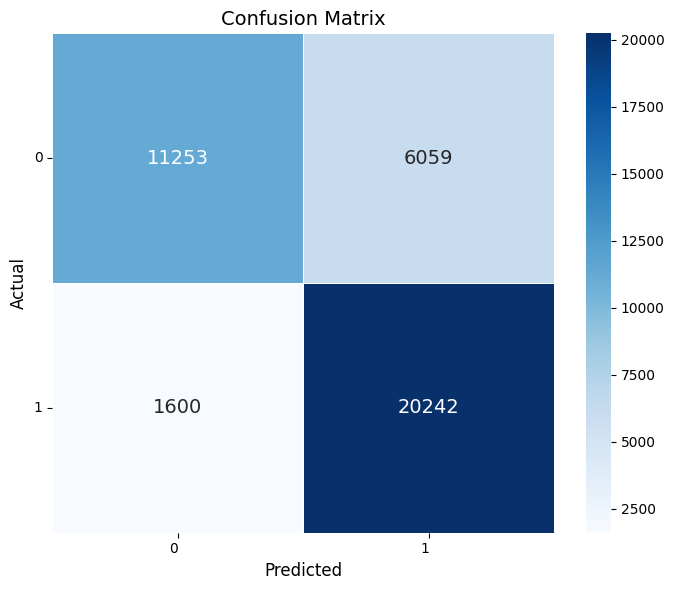

In [62]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = sorted(set(y_true) | set(y_pred))

cmatrix = confusion_matrix(y_true, y_pred, labels=labels)
fontsize = 7
figsize = (7, 6)  # Increased figure size for better readability
cmap = plt.colormaps.get_cmap("Blues")
fig, ax = plt.subplots(figsize=figsize)

sns.heatmap(cmatrix, 
            annot=True, 
            cmap=cmap, 
            cbar=True, 
            ax=ax, 
            linewidths=0.5,
            fmt='d',
            annot_kws={'fontsize': 14},
            xticklabels=labels,
            yticklabels=labels)

plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)

plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right")

plt.tight_layout()
plt.show()

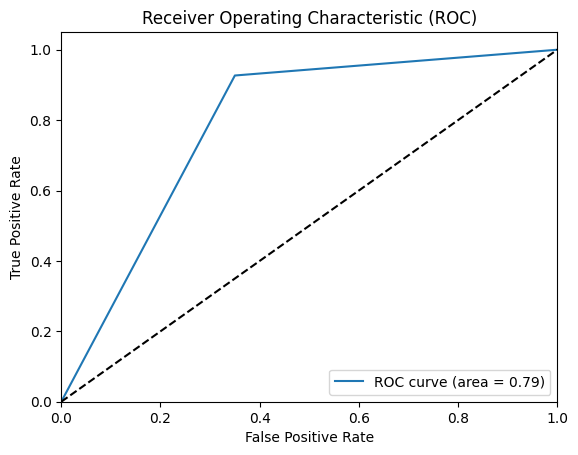

In [61]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.isotonic import IsotonicRegression

y_true = test_labels

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()